In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import sqlite3
from farsnet import *

# class FarsGraph:
#     def __init__(self):
#         df = pd.read_csv('farsnet/synset_relation.csv', delimiter=',')
#         self.G = nx.from_pandas_edgelist(df, source='synsetWords1', target='synsetWords2', edge_attr='type',
#                                          create_using=nx.MultiDiGraph())

class FarsGraph:
    def __init__(self):
        df = pd.read_csv('farsnet/synset_relation.csv', delimiter=',')
        df['synsetWords1'] = df['synsetWords1'].astype(str)
        df['synsetWords2'] = df['synsetWords2'].astype(str)
        self.G = nx.from_pandas_edgelist(df, source='synsetWords1', target='synsetWords2', edge_attr='type',
                                         create_using=nx.MultiDiGraph())

    def visualize(self):
        net = Network(notebook=True, width=1124, height=700)
        net.from_nx(self.G)
        net.show_buttons(filter_=['physics'])
        net.show('farsnet.html')

    def find_pred(self, node):
        return self.G.predecessors(',' + node)

    def find_relations(self, src, des):
        return self.G.get_edge_data(src, des)

    @staticmethod
    def denormalize(token):
        """ Unfortunately, some of FarsNet entries are not normalized so the input should be denormalized to have
        a better chance of string matching! """
        return token.replace("ی", "ي")

    @classmethod
    def get_synsets_by_word(cls, searchKeyword, style):
        searchKeyword = cls.denormalize(searchKeyword)
        if style == "LIKE":
            searchKeyword = "%" + searchKeyword + "%"
        elif style == 'START':
            searchKeyword = "" + searchKeyword + "%"
            style = "LIKE"
        elif style == 'END':
            searchKeyword = "%" + searchKeyword + ""
            style = "LIKE"
        else:
            style = '='
        
        conn = sqlite3.connect('farsnet3.0.db3')  # Replace with your actual database
        cursor = conn.cursor()
        
        query = f"""
            SELECT id, pos, semanticCategory, example, gloss, nofather, noMapping FROM synset
            WHERE synset.id IN (
                SELECT synset.id as synset_id
                FROM word
                INNER JOIN sense ON sense.word = word.id
                INNER JOIN synset ON sense.synset = synset.id
                LEFT OUTER JOIN value ON value.word = word.id
                WHERE word.search_value {style} '{searchKeyword}'
                OR value.search_value {style} '{searchKeyword}'
            )
            OR synset.id IN (
                SELECT sense.synset AS synset_id
                FROM sense
                INNER JOIN sense_relation ON sense.id = sense_relation.sense
                INNER JOIN sense AS sense_2 ON sense_2.id = sense_relation.sense2
                INNER JOIN word ON sense_2.word = word.id
                WHERE sense_relation.type = 'Refer-to'
                AND word.search_value {style} '{searchKeyword}'
            )
            OR synset.id IN (
                SELECT sense_2.synset AS synset_id
                FROM sense
                INNER JOIN sense_relation ON sense.id = sense_relation.sense
                INNER JOIN sense AS sense_2 ON sense_2.id = sense_relation.sense2
                INNER JOIN word ON sense.word = word.id
                WHERE sense_relation.type = 'Refer-to'
                AND word.search_value {style} '{searchKeyword}'
            )
        """
        
        cursor.execute(query)
        results = cursor.fetchall()
        conn.close()
        return results

    @staticmethod
    def get_synset_relation_by_id(synset_id):
        conn = sqlite3.connect('farsnet3.0.db3')  # Replace with your actual database
        query = f"""
            SELECT id, type, synsetWords1, synsetWords2, synset, synset2, reverse_type 
            FROM synset_relation 
            WHERE synset={synset_id} OR
            synset2={synset_id}
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

    @staticmethod
    def get_all_synsets():
        conn = sqlite3.connect('farsnet3.0.db3')  # Replace with your actual database
        query = "SELECT id, pos, semanticCategory, example, gloss, nofather, noMapping FROM synset"
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

# # instantiate jupyter notebook to visualize the graph

            
# # Instantiate the class
# fars_graph = FarsGraph()

# # Visualize the graph
# fars_graph.visualize()

# # Find predecessors of a node
# predecessors = list(fars_graph.find_pred('some_node'))
# print(predecessors)

# # Find relations between two nodes
# relations = fars_graph.find_relations('node1', 'node2')
# print(relations)

# # Get synsets by word
# synsets = FarsGraph.get_synsets_by_word('word', 'LIKE')
# print(synsets)

# # Get synset relation by ID
# synset_relations = FarsGraph.get_synset_relation_by_id(12345)
# print(synset_relations)

# # Get all synsets
# all_synsets = FarsGraph.get_all_synsets()
# print(all_synsets)


In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import sqlite3
from farsnet import *
import json
import datetime

# class FarsGraph: 
#     def __init__(self):
#         df = pd.read_csv('farsnet/synset_relation.csv', delimiter=',')
#         self.G = nx.from_pandas_edgelist(df, source='synsetWords1', target='synsetWords2', edge_attr='type',
#                                          create_using=nx.MultiDiGraph())

class FarsGraph:
    def __init__(self):
        df = pd.read_csv('farsnet/synset_relation.csv', delimiter=',')
        df['synsetWords1'] = df['synsetWords1'].astype(str)
        df['synsetWords2'] = df['synsetWords2'].astype(str)
        self.G = nx.from_pandas_edgelist(df, source='synsetWords1', target='synsetWords2', edge_attr='type',
                                         create_using=nx.MultiDiGraph())

    def visualize(self):
        net = Network(notebook=True, width=1124, height=700)
        net.from_nx(self.G)
        net.show_buttons(filter_=['physics'])
        net.show('farsnet.html')

    def find_pred(self, node):
        return self.G.predecessors(',' + node)

    def find_relations(self, src, des):
        return self.G.get_edge_data(src, des)

    @staticmethod
    def denormalize(token):
        """ Unfortunately, some of FarsNet entries are not normalized so the input should be denormalized to have
        a better chance of string matching! """
        return token.replace("ی", "ي")

    @classmethod
    def get_synsets_by_word(cls, searchKeyword, style):
        searchKeyword = cls.denormalize(searchKeyword)
        if style == "LIKE":
            searchKeyword = "%" + searchKeyword + "%"
        elif style == 'START':
            searchKeyword = "" + searchKeyword + "%"
            style = "LIKE"
        elif style == 'END':
            searchKeyword = "%" + searchKeyword + ""
            style = "LIKE"
        else:
            style = '='
        
        conn = sqlite3.connect('farsnet3.0.db3')  # Replace with your actual database
        cursor = conn.cursor()
        
        query = f"""
            SELECT id, pos, semanticCategory, example, gloss, nofather, noMapping FROM synset
            WHERE synset.id IN (
                SELECT synset.id as synset_id
                FROM word
                INNER JOIN sense ON sense.word = word.id
                INNER JOIN synset ON sense.synset = synset.id
                LEFT OUTER JOIN value ON value.word = word.id
                WHERE word.search_value {style} '{searchKeyword}'
                OR value.search_value {style} '{searchKeyword}'
            )
            OR synset.id IN (
                SELECT sense.synset AS synset_id
                FROM sense
                INNER JOIN sense_relation ON sense.id = sense_relation.sense
                INNER JOIN sense AS sense_2 ON sense_2.id = sense_relation.sense2
                INNER JOIN word ON sense_2.word = word.id
                WHERE sense_relation.type = 'Refer-to'
                AND word.search_value {style} '{searchKeyword}'
            )
            OR synset.id IN (
                SELECT sense_2.synset AS synset_id
                FROM sense
                INNER JOIN sense_relation ON sense.id = sense_relation.sense
                INNER JOIN sense AS sense_2 ON sense_2.id = sense_relation.sense2
                INNER JOIN word ON sense.word = word.id
                WHERE sense_relation.type = 'Refer-to'
                AND word.search_value {style} '{searchKeyword}'
            )
        """
        
        cursor.execute(query)
        results = cursor.fetchall()
        conn.close()
        return results

    @staticmethod
    def get_synset_relation_by_id(synset_id):
        conn = sqlite3.connect('farsnet3.0.db3')  # Replace with your actual database
        query = f"""
            SELECT id, type, synsetWords1, synsetWords2, synset, synset2, reverse_type 
            FROM synset_relation 
            WHERE synset={synset_id} OR
            synset2={synset_id}
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

    @staticmethod
    def get_all_synsets():
        conn = sqlite3.connect('farsnet3.0.db3')  # Replace with your actual database
        query = "SELECT id, pos, semanticCategory, example, gloss, nofather, noMapping FROM synset"
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

# 1. Find All Senses of a Word with Examples and All Related Information
    @classmethod
    def get_all_senses(cls, word):
        word = cls.denormalize(word)
        conn = sqlite3.connect('farsnet3.0.db3')
        query = f"""
            SELECT sense.id, word.search_value, word.defaultValue, sense.synset, synset.pos, synset.semanticCategory, synset.example, synset.gloss
            FROM word
            JOIN sense ON word.id = sense.word
            JOIN synset ON sense.synset = synset.id
            WHERE word.search_value = '{word}'
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

# 2. Identify Synsets with Multiple Senses
    @staticmethod
    def synsets_with_multiple_senses():
        conn = sqlite3.connect('farsnet3.0.db3')
        query = """
            SELECT synset, COUNT(*) as sense_count
            FROM sense
            GROUP BY synset
            HAVING sense_count > 1
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
# 3. Retrieve Words with Their Most Common Sense
    # @staticmethod
    # def words_with_most_common_sense():
    #     conn = sqlite3.connect('farsnet3.0.db3')
    #     query = """
    #         SELECT word.search_value, sense.synset, COUNT(sense.synset) as frequency
    #         FROM word
    #         JOIN sense ON word.id = sense.word
    #         GROUP BY word.search_value, sense.synset
    #         ORDER BY word.search_value, frequency DESC
    #     """
    #     df = pd.read_sql_query(query, conn)
    #     conn.close()
    #     return df.groupby('word').first().reset_index()
    @staticmethod
    def words_with_most_common_sense():
        conn = sqlite3.connect('farsnet3.0.db3')
        query = """
            SELECT word.search_value as word, sense.synset, COUNT(sense.synset) as frequency
            FROM word
            JOIN sense ON word.id = sense.word
            GROUP BY word.search_value, sense.synset
            ORDER BY word.search_value, frequency DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        # return df.groupby('word').first().reset_index()
        # 
        return df.groupby('word').apply(lambda x: x.nlargest(1, 'frequency')).reset_index(drop=True)

    
# 4. List Synsets and Their Corresponding Lexicon Information
    @staticmethod
    def synsets_with_lexicon_info():
        conn = sqlite3.connect('farsnet3.0.db3')
        query = """
            SELECT synset.id, synset.pos, synset.semanticCategory, synset.example, synset.gloss, word.search_value
            FROM synset
            JOIN sense ON synset.id = sense.synset
            JOIN word ON sense.word = word.id
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
# 5. Extract Senses and Their Synsets for a Particular Part of Speech
    @staticmethod
    def senses_by_pos(pos):
        conn = sqlite3.connect('farsnet3.0.db3')
        query = f"""
            SELECT sense.id, sense.synset, synset.pos, word.search_value
            FROM sense
            JOIN synset ON sense.synset = synset.id
            JOIN word ON sense.word = word.id
            WHERE synset.pos = '{pos}'
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
# 6. Determine the Distribution of Senses Across Different Parts of Speech
    @staticmethod
    def senses_distribution():
        conn = sqlite3.connect('farsnet3.0.db3')
        query = """
            SELECT synset.pos, COUNT(sense.id) as sense_count
            FROM sense
            JOIN synset ON sense.synset = synset.id
            GROUP BY synset.pos
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
# 7. Identify Unique Senses for a Given Semantic Category
    @staticmethod
    def unique_senses_by_semantic_category(category):
        conn = sqlite3.connect('farsnet3.0.db3')
        query = f"""
            SELECT DISTINCT sense.id, sense.synset, word.search_value
            FROM sense
            JOIN synset ON sense.synset = synset.id
            JOIN word ON sense.word = word.id
            WHERE synset.semanticCategory = '{category}'
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
# 8. Retrieve Examples for Synsets with a Specific Gloss Pattern
    @staticmethod
    def synsets_with_gloss_pattern(pattern):
        conn = sqlite3.connect('farsnet3.0.db3')
        query = f"""
            SELECT synset.id, synset.example, synset.gloss
            FROM synset
            WHERE synset.gloss LIKE '%{pattern}%'
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
# 9. Find Synsets with No Direct Mapping and Their Glosses
    @staticmethod
    def synsets_with_no_mapping():
        conn = sqlite3.connect('farsnet3.0.db3')
        query = """
            SELECT id, gloss
            FROM synset
            WHERE noMapping = 1
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

    # @classmethod
    # def get_all_synsets_for_all_words(cls):
    #     conn = sqlite3.connect('farsnet3.0.db3')
    #     query = """
    #         SELECT word.search_value as word, sense.id as sense_id, sense.synset, synset.pos, synset.semanticCategory, 
    #                synset.example, synset.gloss, word.pos as word_pos, word.avaInfo, word.defaultValue
    #         FROM word
    #         JOIN sense ON word.id = sense.word
    #         JOIN synset ON sense.synset = synset.id
    #     """
    #     df = pd.read_sql_query(query, conn)
    #     conn.close()

    #     # Group by word and create a list of synsets for each word
    #     result = {}
    #     for index, row in df.iterrows():
    #         word = row['word']
    #         sense_info = {
    #             'sense_id': row['sense_id'],
    #             'synset_id': row['synset'],
    #             'pos': row['pos'],
    #             'semanticCategory': row['semanticCategory'],
    #             'example': row['example'],
    #             'gloss': row['gloss'],
    #             'word_pos': row['word_pos'],
    #             'avaInfo': row['avaInfo'],
    #             'defaultValue': row['defaultValue']
    #         }
    #         if word not in result:
    #             result[word] = []
    #         result[word].append(sense_info)

    #     # Save the result as a JSON file
    #     with open('all_synsets_for_all_words.json', 'w', encoding='utf-8') as f:
    #         json.dump(result, f, ensure_ascii=False, indent=4)

    #     return result

    @staticmethod
    def get_all_senses_for_all_words():
        conn = sqlite3.connect('farsnet3.0.db3')
        query = """
            SELECT sense.id, word.search_value, word.defaultValue, sense.synset, synset.pos, synset.semanticCategory, 
                   synset.example, synset.gloss
            FROM word
            JOIN sense ON word.id = sense.word
            JOIN synset ON sense.synset = synset.id
            ORDER BY word.search_value
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        timestamp = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
        df.to_csv('all_senses_for_all_words.csv', index=False, encoding='utf-8-sig')

        return df

    @classmethod
    def get_all_senses_for_words(cls, words_file):
        # Load words from CSV file
        words_df = pd.read_csv(words_file)
        words = words_df['word'].tolist()

        conn = sqlite3.connect('farsnet3.0.db3')
        result = {}

        for word in words:
            word_denormalized = cls.denormalize(word)
            query = f"""
                SELECT sense.id, word.search_value, word.defaultValue, sense.synset, synset.pos, synset.semanticCategory, 
                       synset.example, synset.gloss
                FROM word
                JOIN sense ON word.id = sense.word
                JOIN synset ON sense.synset = synset.id
                WHERE word.search_value = '{word_denormalized}' OR word.defaultValue = '{word_denormalized}'
            """
            df = pd.read_sql_query(query, conn)

            # Process the DataFrame and construct the desired JSON structure
            senses = []
            for _, row in df.iterrows():
                sense_info = {
                    # "meaning": row['gloss'],
                    "example": row['example'],
                    # "pos": row['pos'],
                    # "semantic_category": row['semanticCategory'],
                    # "sense_id": row['id'],
                    # "synset_id": row['synset'],
                }
                senses.append(sense_info)
            result[word] = senses

        conn.close()

        import datetime 
        # Save the result as a JSON file
        timestamp = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M")
        with open(f'senses_for_words_{timestamp}.json', 'w', encoding='utf-8') as f:
            json.dump(result, f, ensure_ascii=False, indent=4)
        return result


In [2]:
fars_graph = FarsGraph()

In [3]:
all_senses = fars_graph.get_all_senses_for_all_words()

In [4]:
all_senses

,id,search_value,defaultValue,synset,pos,semanticCategory,example,gloss
0,18200,"""تغييريافتندرحجم""","""تغييريافتن‌درحجم""",7732,Verb,change,--نامعلوم--:حجم آب يا يخ زدن تغيير مي‌کند. *,--نامعلوم--: ايجاد شدن تغيير در حجم يا اندازه ...
1,18202,"""خلقکردنذهني""","""خلق کردن ذهني""",9267,Verb,creation,--نامعلوم--:بسياري از داستان‌ها را خود نويسندگ...,--نامعلوم--:به وجود آوردن چيزي ذهني *
2,143495,(ره),(ره),45149,Noun,STATE,دهخدا:سعدي عليه الرحمه شاعر بزرگ ايران در قرن ...,دهخدا:جمله ٔ اسميه ٔ دعايي به معني رحمت و بخشا...
3,159888,(س),(س),45143,Noun,ACT,ويکي شيعه:حضرت معصومه سلام الله عليها دختر اما...,دهخدا:درود خدا بر او باد! اين جمله دعايي را پس...
4,143465,(ص),(ص),45153,Noun,ACT,ويکي شيعه:گويند پيامبر (صلي الله عليه و آله و ...,معين:درود خداوند بر او و خاندانش باد. جمله دعا...
...,...,...,...,...,...,...,...,...
110086,23969,گچکاريکردن,گچ‌کاري کردن,8954,Verb,contact,--نامعلوم--:ديوارها را گچکاري مي کنيم و بعد رن...,--نامعلوم--:با گچ سطح ديواري را پوشاندن *
110087,126722,گچکشيدن,گچ کشيدن,8954,Verb,contact,--نامعلوم--:ديوارها را گچکاري مي کنيم و بعد رن...,--نامعلوم--:با گچ سطح ديواري را پوشاندن *
110088,106520,گچگرفتن,گچ گرفتن,34051,Verb,contact,دروازه‌بان تيم‌ملي دست خود را گچ گرفت.,با گچ پوشيدن استخوان شکسته
110089,107819,گچگرفتن,گچ‌گرفتن,43263,Noun,ARTIFACT,--ازخودم--:براي گچ گرفتن دستم به بيمارستان رفت...,سخن:قرار دادن قالب محکمي از جنس گچ يا مواد ديگ...


In [15]:
fars_graph.get_all_senses('شیر')

,id,search_value,defaultValue,synset,pos,semanticCategory,example,gloss
0,32617,شير,شير,14005,Noun,BODY,غذاي اصلي کودکان تا 2 سالگي بايد شير مادر باشد,مايعي که از غده هاي پستاني انسان ماده ترشح مي ...
1,32618,شير,شير,14014,Noun,LOCATION,--نامعلوم--:وارد برج اسد شده‌ايم *,--نامعلوم--:برج پنجم از برج هاي دوازده گانه، پ...
2,32619,شير,شير,14012,Noun,GROUP,شيران دلاور عرصه هاي نبرد حق بر باطل,شخص شجاع ، دلاور و پهلوان
3,32620,شير,شير,14006,Noun,FOOD,او براي پيدا کردن شير همه ي داروخانه ها را زير...,ماده اي خوراکي شامل شيري که آب آن را گرفته اند...
4,32621,شير,شير,14007,Noun,ARTIFACT,آن شير را از روي قفسه بده تا براي بچه غذا درست...,قوطي حاوي شير خشک
5,32622,شير,شير,14013,Noun,ARTIFACT,کاپيتان تيم در ابتداي مسابقه شير را براي تعيين...,سمتي از سکه که اسکچ، نشان يا طرحي گرافيکي روي ...
6,32623,شير,شير,14015,Noun,BODY,حيوانات اگر دچار سوتغذيه باشند از شير دادن به ...,مايعي خوراکي که از پستان پستانداران ترشح مي ش...
7,32624,شير,شير,11682,Noun,FOOD,--نامعلوم--:شير را گرم کن و بعد بخور *,--نامعلوم--:مايعي خوراکي که از گاو و گوسفند مي...
8,32625,شير,شير,14011,Noun,SUBSTANCE,شيره ي درخت لباسش را کثيف کرد,مايعي سفيد که در ساقه ي بعضي از گياهان وجود دارد
9,32626,شير,شير,14008,Noun,ARTIFACT,شير توي يخچال است,قوطي يا بطري حاوي شير گاو يا گوسفند


In [ ]:
import pandas as pd
import sqlite3
import json

class SynsetRetriever:
    @staticmethod
    def denormalize(token):
        """ Unfortunately, some of FarsNet entries are not normalized so the input should be denormalized to have
        a better chance of string matching! """
        return token.replace("ی", "ي")

    @classmethod
    def get_all_senses_for_words(cls, words_file):
        words_df = pd.read_csv(words_file)
        words = words_df['word'].tolist()

        conn = sqlite3.connect('farsnet3.0.db3')
        result = {}

        for word in words:
            word_denormalized = cls.denormalize(word)
            query = f"""
                SELECT sense.id AS sense_id, word.search_value, word.avaInfo, sense.synset AS synset_id, synset.pos, 
                       synset.semanticCategory, synset.example, synset.gloss,
                       GROUP_CONCAT(sw.search_value, ', ') AS synonyms
                FROM word
                JOIN sense ON word.id = sense.word
                JOIN synset ON sense.synset = synset.id
                JOIN sense s2 ON s2.synset = synset.id
                JOIN word sw ON sw.id = s2.word
                WHERE word.search_value = '{word_denormalized}'
                GROUP BY sense.id, word.search_value, word.avaInfo, sense.synset, synset.pos, 
                         synset.semanticCategory, synset.example, synset.gloss
            """
            df = pd.read_sql_query(query, conn)
            
            senses = []
            for _, row in df.iterrows():
                # Retrieve additional information using the sense_id and synset_id
                sense_id = row['sense_id']
                synset_id = row['synset_id']

                # Get related senses
                related_senses_query = f"""
                    SELECT sense2, senseWord2
                    FROM sense_relation
                    WHERE sense = {sense_id}
                """
                related_senses_df = pd.read_sql_query(related_senses_query, conn)
                related_senses = related_senses_df.to_dict('records')

                # Get related synsets
                related_synsets_query = f"""
                    SELECT synset2, synsetWords2
                    FROM synset_relation
                    WHERE synset = {synset_id}
                """
                related_synsets_df = pd.read_sql_query(related_synsets_query, conn)
                related_synsets = related_synsets_df.to_dict('records')

                # Get WordNet synset information
                wordnet_synsets_query = f"""
                    SELECT wnPos, wnOffset, example, gloss
                    FROM wordnetsynset
                    WHERE synset = {synset_id}
                """
                wordnet_synsets_df = pd.read_sql_query(wordnet_synsets_query, conn)
                wordnet_synsets = wordnet_synsets_df.to_dict('records')
            
                # Get gloss and example information
                gloss_example_query = f"""
                    SELECT type, content
                    FROM gloss_and_example
                    WHERE synset = {synset_id}
                """
                gloss_example_df = pd.read_sql_query(gloss_example_query, conn)
                gloss_example = gloss_example_df.to_dict('records')

                meaning = row['gloss']
                example = row['example']

                sense_info = {
                    "ava_info": row['avaInfo'],
                    "meaning": meaning,
                    "example": example,
                    "pos": row['pos'],
                    "semantic_category": row['semanticCategory'],
                    "synonym_set": row['synonyms'].split(', '),

                    # "sense_id": row['sense_id'],
                    # "synset_id": row['synset_id'],

                    # "related_senses": related_senses,

                    # "related_synsets": related_synsets,
                    # "wordnet_synsets": wordnet_synsets,
                }
                senses.append(sense_info)

            result[word] = senses

        conn.close()

        import datetime
        timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
        file_name = f'word-info-from-Farsnet-{timestamp}.json'
        with open(file_name, 'w', encoding='utf-8') as f:
            json.dump(result, f, ensure_ascii=False, indent=4)
        return result

file_path = 'words_06-08-2024-06-51-49.csv'
SynsetRetriever.get_all_senses_for_words(file_path)

In [3]:
# Instantiate the class
fars_graph = FarsGraph()

In [ ]:
# Visualize the graph
fars_graph.visualize()

In [ ]:
# Find predecessors of a node
from pprint import pprint
pprint(list(fars_graph.find_pred('گذشته')))

In [ ]:
# Find relations between two nodes
print(fars_graph.find_relations('گرم', 'سرد'))

In [ ]:
# Get synsets by word
pprint(fars_graph.get_synsets_by_word('خوب', 'LIKE'))

In [ ]:
# Get synset relations by id
print(fars_graph.get_synset_relation_by_id(1))

In [ ]:
# Get all synsets
print(fars_graph.get_all_synsets())

In [ ]:
# # Instantiate the class
# fars_graph = FarsGraph()

# # Visualize the graph
# fars_graph.visualize()

# # Find predecessors of a node
# print(fars_graph.find_pred('سگ'))

# # Find relations between two nodes
# print(fars_graph.find_relations('سگ', 'گربه'))

# # Get synsets by word
# print(fars_graph.get_synsets_by_word('سگ', 'LIKE'))

# # Get synset relations by id
# print(fars_graph.get_synset_relation_by_id(1))

# # Get all synsets
# print(fars_graph.get_all_synsets())

# # Denormalize a token
# print(fars_graph.denormalize('سگ'))


#######################################################
# predecessors = list(fars_graph.find_pred('some_node'))
# print(predecessors)

# # Find relations between two nodes
# relations = fars_graph.find_relations('node1', 'node2')
# print(relations)

# # Get synsets by word
# synsets = FarsGraph.get_synsets_by_word('word', 'LIKE')
# print(synsets)

# # Get synset relation by ID
# synset_relations = FarsGraph.get_synset_relation_by_id(12345)
# print(synset_relations)

# # Get all synsets
# all_synsets = FarsGraph.get_all_synsets()
# print(all_synsets)


In [ ]:
# # Instantiate the class
# fars_graph = FarsGraph()

In [ ]:
import sqlite3

def inspect_schema():
    conn = sqlite3.connect('farsnet3.0.db3')
    cursor = conn.cursor()

    # Inspect word table
    cursor.execute("PRAGMA table_info(word)")
    word_schema = cursor.fetchall()

    # Inspect sense table
    cursor.execute("PRAGMA table_info(sense)")
    sense_schema = cursor.fetchall()

    # Inspect synset table
    cursor.execute("PRAGMA table_info(synset)")
    synset_schema = cursor.fetchall()

    conn.close()

    return word_schema, sense_schema, synset_schema

word_schema, sense_schema, synset_schema = inspect_schema()

print("Word Table Schema:", word_schema)
print("Sense Table Schema:", sense_schema)
print("Synset Table Schema:", synset_schema)

In [4]:
all_senses = fars_graph.get_all_senses('شیر')
display(all_senses)

,id,search_value,synset,pos,semanticCategory,example,gloss
0,32617,شير,14005,Noun,BODY,غذاي اصلي کودکان تا 2 سالگي بايد شير مادر باشد,مايعي که از غده هاي پستاني انسان ماده ترشح مي ...
1,32618,شير,14014,Noun,LOCATION,--نامعلوم--:وارد برج اسد شده‌ايم *,--نامعلوم--:برج پنجم از برج هاي دوازده گانه، پ...
2,32619,شير,14012,Noun,GROUP,شيران دلاور عرصه هاي نبرد حق بر باطل,شخص شجاع ، دلاور و پهلوان
3,32620,شير,14006,Noun,FOOD,او براي پيدا کردن شير همه ي داروخانه ها را زير...,ماده اي خوراکي شامل شيري که آب آن را گرفته اند...
4,32621,شير,14007,Noun,ARTIFACT,آن شير را از روي قفسه بده تا براي بچه غذا درست...,قوطي حاوي شير خشک
5,32622,شير,14013,Noun,ARTIFACT,کاپيتان تيم در ابتداي مسابقه شير را براي تعيين...,سمتي از سکه که اسکچ، نشان يا طرحي گرافيکي روي ...
6,32623,شير,14015,Noun,BODY,حيوانات اگر دچار سوتغذيه باشند از شير دادن به ...,مايعي خوراکي که از پستان پستانداران ترشح مي ش...
7,32624,شير,11682,Noun,FOOD,--نامعلوم--:شير را گرم کن و بعد بخور *,--نامعلوم--:مايعي خوراکي که از گاو و گوسفند مي...
8,32625,شير,14011,Noun,SUBSTANCE,شيره ي درخت لباسش را کثيف کرد,مايعي سفيد که در ساقه ي بعضي از گياهان وجود دارد
9,32626,شير,14008,Noun,ARTIFACT,شير توي يخچال است,قوطي يا بطري حاوي شير گاو يا گوسفند


In [4]:
all_senses = fars_graph.get_all_senses('cd')
display(all_senses)

,id,search_value,synset,pos,semanticCategory,example,gloss
0,104646,cd,33404,Noun,SUBSTANCE,--نامعلوم--:کادميوم به‌راحتي با چاقو بريده مي‌...,--نامعلوم--:عنصر شيميايي نسبتاً کمياب، نرم و ا...
1,165249,cd,26968,Noun,ARTIFACT,--نامعلوم--:به گزارش خبرگزاري مهر، به نقل از ر...,--نامعلوم--:يک لوح گرد نوري است که براي انبار ...
2,167793,cd,32321,Noun,QUANTITY,--نامعلوم--:يک شمع معمولي با تقريب نه‌چندان خو...,--نامعلوم--:يکاي شدت نور در دستگاه بين‌المللي ...


In [ ]:
import json
from IPython.display import display, JSON

senses_for_words = fars_graph.get_all_senses_for_words('words.csv')

# Display a subset of the JSON for readability
# display(JSON(senses_for_words))

In [ ]:
import json
from IPython.display import display, JSON

senses_for_words = fars_graph.get_all_senses_for_words('step-1/words_06-08-2024-06-51-49.csv')

# step-1/words_06-08-2024-06-51-49.csv

In [5]:
import json
import datetime
from IPython.display import display, JSON

senses_for_words = fars_graph.get_all_senses_for_words('/workspaces/FarsNet/step-3/100_words.csv')

# step-1/words_06-08-2024-06-51-49.csv

AttributeError: module 'datetime' has no attribute 'now'

In [12]:
import json
import datetime

import os
if not os.path.exists('step-2'):
    os.makedirs('step-2')
timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S") 
with open(f'step-2/senses_for_words_{timestamp}.json', 'w', encoding='utf-8') as f:
    json.dump(senses_for_words, f, ensure_ascii=False, indent=4)

In [27]:
# display({k: senses_for_words[k] for k in list(senses_for_words)[:10]})

# process my json to have it as a dataframe
import pandas as pd
import json

with open('step-2/word-info-from-Farsnet-08-06-2024-10-46.json') as f:
    data = json.load(f)

    # sense_info = {
    #     "ava_info": row['avaInfo'],
    #     "meaning": meaning,
    #     "example": example,
    #     "pos": row['pos'],
    #     "semantic_category": row['semanticCategory'],
    #     "sense_id": row['sense_id'],
    #     "synset_id": row['synset_id'],
    #     "synonyms": row['synonyms'].split(', '),
    #     "related_senses": related_senses,
    #     "related_synsets": related_synsets,
    #     "wordnet_synsets": wordnet_synsets,
    # }

In [34]:
data_list = []
for word, senses in data.items():
    for sense in senses:
        sense_info = {
            "word": word,
            "ava_info": sense['ava_info'],
            "sense_id": sense['sense_id'],
            "synset_id": sense['synset_id'],
            "meaning": sense['meaning'],
            "example": sense['example'],
            "pos": sense['pos'],
            "semantic_category": sense['semantic_category'],
            "synonyms": sense['synonyms'],
            "related_senses": sense['related_senses'],
            "related_synsets": sense['related_synsets'],
            "wordnet_synsets": sense['wordnet_synsets'],
        }

        data_list.append(sense_info)

df = pd.DataFrame(data_list)
df.head()

,word,ava_info,sense_id,synset_id,meaning,example,pos,semantic_category,synonyms,related_senses,related_synsets,wordnet_synsets
0,گردویی,gerduyi,49220,17689,ساخته شده از گردو,بستني گردويي همراه با قهوه بسيار دلچسب و لذت‌ب...,Adjective,material,[گردويي],[],[],"[{'wnPos': 'NOUN', 'wnOffset': '7787188', 'exa..."
1,گردویی,gerduyi,59050,24677,رنگي است از خانواده رنگ قهوه اي، شبيه به رنگ پ...,کابينت هاي منزل جديد به رنگ گردويي است.,Noun,ATTRIBUTE,"[گردويي, رنگگردويي]","[{'sense2': 65131, 'senseWord2': 'گردو'}]",[],"[{'wnPos': 'NOUN', 'wnOffset': '4979195', 'exa..."
2,گردویی,gerduyi,63973,26833,--نامعلوم--:به رنگ پوست سخت گردو *,--نامعلوم--:کابينتهاي گردويي آشپزخانه را نپسند...,Adjective,conceptual,"[گردويي, گردوييرنگ]","[{'sense2': 65131, 'senseWord2': 'گردو'}, {'se...","[{'synset2': 12919, 'synsetWords2': 'رنگ, لون,...",[]
3,بادقت,bAdeqqat,24194,1562,--نامعلوم--:ويژگي آن‌که توجه، دقت و هوشياري با...,--نامعلوم--:آدم باريک‌بيني است و همه جزئيات را...,Adjective,behavior,"[تيزبين, دقيق, نکتهسنج, بادقت, باريکبين, موشکا...",[],"[{'synset2': 27774, 'synsetWords2': 'سربه‌هوا,...","[{'wnPos': 'ADJECTIVE', 'wnOffset': '1748764',..."
4,بادقت,bAdeqqat,62131,15306,با تمرکز و دقت,متن کتاب را دقيق خواند و چندين اشکال صوري و مح...,Adverb,کيفيت,"[دقيق, دقيقا, بادقت, بهدقت]","[{'sense2': 30744, 'senseWord2': 'دقت'}, {'sen...","[{'synset2': 26888, 'synsetWords2': 'موبه‌مو, ...","[{'wnPos': 'ADVERB', 'wnOffset': '154701', 'ex..."


In [35]:
df

,word,ava_info,sense_id,synset_id,meaning,example,pos,semantic_category,synonyms,related_senses,related_synsets,wordnet_synsets
0,گردویی,gerduyi,49220,17689,ساخته شده از گردو,بستني گردويي همراه با قهوه بسيار دلچسب و لذت‌ب...,Adjective,material,[گردويي],[],[],"[{'wnPos': 'NOUN', 'wnOffset': '7787188', 'exa..."
1,گردویی,gerduyi,59050,24677,رنگي است از خانواده رنگ قهوه اي، شبيه به رنگ پ...,کابينت هاي منزل جديد به رنگ گردويي است.,Noun,ATTRIBUTE,"[گردويي, رنگگردويي]","[{'sense2': 65131, 'senseWord2': 'گردو'}]",[],"[{'wnPos': 'NOUN', 'wnOffset': '4979195', 'exa..."
2,گردویی,gerduyi,63973,26833,--نامعلوم--:به رنگ پوست سخت گردو *,--نامعلوم--:کابينتهاي گردويي آشپزخانه را نپسند...,Adjective,conceptual,"[گردويي, گردوييرنگ]","[{'sense2': 65131, 'senseWord2': 'گردو'}, {'se...","[{'synset2': 12919, 'synsetWords2': 'رنگ, لون,...",[]
3,بادقت,bAdeqqat,24194,1562,--نامعلوم--:ويژگي آن‌که توجه، دقت و هوشياري با...,--نامعلوم--:آدم باريک‌بيني است و همه جزئيات را...,Adjective,behavior,"[تيزبين, دقيق, نکتهسنج, بادقت, باريکبين, موشکا...",[],"[{'synset2': 27774, 'synsetWords2': 'سربه‌هوا,...","[{'wnPos': 'ADJECTIVE', 'wnOffset': '1748764',..."
4,بادقت,bAdeqqat,62131,15306,با تمرکز و دقت,متن کتاب را دقيق خواند و چندين اشکال صوري و مح...,Adverb,کيفيت,"[دقيق, دقيقا, بادقت, بهدقت]","[{'sense2': 30744, 'senseWord2': 'دقت'}, {'sen...","[{'synset2': 26888, 'synsetWords2': 'موبه‌مو, ...","[{'wnPos': 'ADVERB', 'wnOffset': '154701', 'ex..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1625,فرفره,ferfere,64390,27007,اسباب بازي‌اي معمولا چوبي يا پلاستيکي که با ان...,يکي از سرگرمي هاي کودکان نسل ما بازي با فرفره‌...,Noun,ARTIFACT,"[فرفره, فرفرهچوبي]",[],"[{'synset2': 12846, 'synsetWords2': 'بازيچه, ا...","[{'wnPos': 'NOUN', 'wnOffset': '4461511', 'exa..."
1626,فرفره,ferfere,137710,43610,ويکي پديا:نام گياهي دارويي است از خانواده گل‌س...,ويکي پديا:از ريشه و برگ گياه پاي کره اسبي، برا...,Noun,PLANT,"[فرفره, پايخر, گياهپايخر, پايکرهاسبي, گياهپايک...",[],"[{'synset2': 38117, 'synsetWords2': 'گياه دارو...","[{'wnPos': 'NOUN', 'wnOffset': '12049795', 'ex..."
1627,زهرماری,zahremAri,137132,11687,--نامعلوم--:نوشيدني‌هايي هستند که اتانول دارند...,--نامعلوم--:مصرف بيش از حد الکل (اوردوز) و مسم...,Noun,FOOD,"[الکل, مسکر, مشروب, مشروبالکلي, نوشيدنيالکلي, ...",[],"[{'synset2': 13183, 'synsetWords2': 'نوشيدني, ...","[{'wnPos': 'Noun', 'wnOffset': '7900542', 'exa..."
1628,زهرماری,zahremAri,137133,11056,--نامعلوم--:دارويي اعتياد آور که مصرف مقدار کم...,--نامعلوم--:مخدرها در درمان بيماري کاربردهايي ...,Noun,ARTIFACT,"[مادهمخدر, دارويمخدر, مخدر, موادمخدر, زهرماري,...",[],"[{'synset2': 12789, 'synsetWords2': 'دوا'}, {'...","[{'wnPos': 'Noun', 'wnOffset': '3814104', 'exa..."


In [36]:
grouped = df.groupby('word').size().reset_index(name='frequency')
df = df.merge(grouped, on='word')
df = df.sort_values('frequency', ascending=False)
df = df.drop_duplicates('word')

In [37]:
df

,word,ava_info,sense_id,synset_id,meaning,example,pos,semantic_category,synonyms,related_senses,related_synsets,wordnet_synsets,frequency
794,ارام,'ArAm,64329,2455,داراي سرعت کم و ناچيز,با اين اتوبوس کند و قديمي دير به کلاس مي رسم,Adjective,temporal,"[ارام, اهسته, کند, يواش]",[],[],"[{'wnPos': 'Adjective', 'wnOffset': '983718', ...",12
1614,ردکردن,rad kardan,20879,7796,--نامعلوم--:نپذيرفتن و قبول نکردن هديه يا پيشک...,--نامعلوم--:بهانه آورد و دعوت مرا رد کرد./دست ...,Verb,possession,"[دستردبهسينه(کسي)زدن, ردکردن, نپذيرفتن, دستردب...",[],"[{'synset2': 7614, 'synsetWords2': 'قبول کردن,...","[{'wnPos': 'Verb', 'wnOffset': '2242120', 'exa...",10
1033,برپاکردن,barpA kardan,24898,14502,ترتيب دادن مقدمات کاري و آن را مرحله به مرحله ...,برگزاري جشن عروسي بسيار باشکوه بود.,Noun,ACT,"[برقراري, دايرنمودن, دايرکردن, برپانمودن, برپا...","[{'sense2': 24899, 'senseWord2': 'برپايي'}]","[{'synset2': 11614, 'synsetWords2': 'مراسم شاد...","[{'wnPos': 'VERB', 'wnOffset': '2448714', 'exa...",9
1527,عملکردن,'amal kardan,25710,10229,انجام دادن آنچه شخص ادعا مي کند يا در حرف و نظ...,عمل به حرفهاي بزرگ مهم است نه فقط ابراز آنها,Noun,TOPS,"[عملکردن, عمل]",[],"[{'synset2': 12785, 'synsetWords2': 'نيل, دست‌...","[{'wnPos': 'NOUN', 'wnOffset': '30657', 'examp...",8
279,خواباندن,xAbAndan,20407,9616,--نامعلوم--:کسي را وادار به دراز کشيدن کردن يا...,--نامعلوم--: کتابها را روي ميز بخوابان *,Verb,contact,"[خواباندن, خوابانيدن]","[{'sense2': 30302, 'senseWord2': 'خواب'}]","[{'synset2': 9211, 'synsetWords2': 'استقرار دا...","[{'wnPos': 'Verb', 'wnOffset': '1547474', 'exa...",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,طرحواره,tarhvAre,145228,13596,--نامعلوم--:تصوير مقدماتي يا شکل کلي چيزي که م...,--نامعلوم--:طرح نقاش از چند خط تشکيل شده بود *,Noun,ARTIFACT,"[گرده, طرح, طرحواره, انگاره, گرته]",[],"[{'synset2': 10983, 'synsetWords2': 'هنر گرافي...","[{'wnPos': 'NOUN', 'wnOffset': '4234206', 'exa...",3
652,همشکل,hamSekl,63791,26793,مانند يکديگر,سعي مي کردند کارهايشان را مثل هم انجام دهند*آن...,Adverb,تشبيه,"[يکسان, شبيه, همشکل, همسان, همانند, مشابه, يکج...",[],[],"[{'wnPos': 'ADVERB', 'wnOffset': '70003', 'exa...",3
649,بیمناک,bimnAk,62509,17178,--نامعلوم--:با حالت ترس *,--نامعلوم--:پسرک، ترسان در را به روي پدرو مادر...,Adverb,حالت,"[هراسان, ترسان, بيمناک, خايف, هراسناک, خايفانه...","[{'sense2': 28242, 'senseWord2': 'بيم'}]","[{'synset2': 7649, 'synsetWords2': 'ترسيدن, وا...","[{'wnPos': 'ADVERB', 'wnOffset': '200994', 'ex...",3
646,یلخی,yelxi,146652,46088,سخن:بدون نظم‌وترتيب *,سخن:تهراني که ديگر مثل منِ دهاتي يلخي زندگي نم...,Adverb,کيفيت,[يلخي],[],"[{'synset2': 42972, 'synsetWords2': 'هرج‌و‌مرج...","[{'wnPos': 'ADJECTIVE', 'wnOffset': '2399137',...",3


In [43]:
# show freq more than equal 5
temp = df[df['frequency'] >= 4]
# reset index 
temp = temp.reset_index(drop=True)
temp
# bring me back the top 100
temp = temp.head(100)
temp
# bring me back the word list of temp
l = temp['word'].to_list()

In [45]:
import csv
timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
with open(f'words-to-search-in-MirasText-{timestamp}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["word"])
    for word in l:
        writer.writerow([word])

In [ ]:
# Display a subset of the JSON for readability
display(JSON(senses_for_words))

In [ ]:
import json

def merge_json_files(file1, file2, output_file):
    with open(file1, 'r', encoding='utf-8') as f:
        data1 = json.load(f)

    with open(file2, 'r', encoding='utf-8') as f:
        data2 = json.load(f)

    merged_data = data1

    for word, senses in data2.items():
        if word in merged_data:
            existing_senses = {json.dumps(sense, ensure_ascii=False) for sense in merged_data[word]}
            new_senses = {json.dumps(sense, ensure_ascii=False) for sense in senses}
            combined_senses = existing_senses.union(new_senses)
            merged_data[word] = [json.loads(sense) for sense in combined_senses]
        else:
            merged_data[word] = senses

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(merged_data, f, ensure_ascii=False, indent=4)

merge_json_files('senses_for_words_1.json', 'senses_for_words_2.json', 'merged_senses_for_words.json')

In [ ]:
with open('merged_senses_for_words.json', encoding='utf8') as JSONFile:
    data = json.load(JSONFile)
print(len(data))

keys_to_remove = []
for key, value in data.items():
    if len(value) <= 1:
        keys_to_remove.append(key)

for key in keys_to_remove:
    del data[key]

with open('merged_senses_for_words.json', 'w', encoding='utf8') as JSONFile:
    json.dump(data, JSONFile, ensure_ascii=False, indent=4)

In [ ]:
with open('merged_senses_for_words.json', encoding='utf8') as JSONFile:
    data = json.load(JSONFile)
print(len(data))

unique_words = list(data.keys())
print(unique_words)

In [5]:
all_senses = fars_graph.get_all_senses_for_all_words()

In [51]:
import time
import numpy as np
import pandas as pd
from hazm import Normalizer
from parsivar import Normalizer as ParsivarNormalizer

def optimize_normalize_text(text):
    normalizer = Normalizer(persian_numbers=True)
    norm = ParsivarNormalizer(half_space_char=True)
    
    # Track individual normalization times
    global normalization_times
    normalization_times = []
    
    def normalize_single(x):
        start = time.time()
        result = norm.normalize(normalizer.normalize(x))
        end = time.time()
        normalization_times.append(end - start)
        return result
    
    return np.vectorize(normalize_single)(text)


# Normalize all text fields in the DataFrame
start = time.time()
all_senses['defaultValue'] = optimize_normalize_text(all_senses['defaultValue'])
end = time.time()
total_time = end - start

# Calculate statistics using Pandas describe()
normalization_times_df = pd.Series(normalization_times)
stats = normalization_times_df.describe()

print(f"Total time taken to normalize all text fields: {total_time:.6f} seconds")
print("\nNormalization Time Statistics:")
print(stats)

Total time taken to normalize all text fields: 2.296627 seconds

Normalization Time Statistics:
count    3113.000000
mean        0.000206
std         0.000082
min         0.000167
25%         0.000177
50%         0.000180
75%         0.000193
max         0.003140
dtype: float64


/tmp/ipykernel_29519/4226885984.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_senses['defaultValue'] = optimize_normalize_text(all_senses['defaultValue'])


In [61]:
pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 45.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 30.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
# from numba import jit
# import time
# import numpy as np
# import pandas as pd
# from hazm import Normalizer
# from parsivar import Normalizer as ParsivarNormalizer

# @jit(nopython=True)
# def normalize_text(num_texts, texts, results):
#     normalizer = Normalizer(persian_numbers=True)
#     norm = ParsivarNormalizer(half_space_char=True)
#     for i in range(num_texts):
#         results[i] = norm.normalize(normalizer.normalize(texts[i]))
#     return results

# def optimize_normalize_text(texts):
#     num_texts = len(texts)
#     results = np.empty(num_texts, dtype=object)
#     normalize_text(num_texts, texts, results)
#     return results

# # Normalize all text fields in the DataFrame
# start = time.time()
# all_senses['defaultValue'] = optimize_normalize_text(all_senses['defaultValue'].values)
# end = time.time()
# total_time = end - start

# print(f"Total time taken to normalize all text fields: {total_time:.6f} seconds")


In [8]:
# pip install scipy==1.12
# 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# apply 

In [52]:
all_senses

,id,search_value,defaultValue,synset,pos,semanticCategory,example,gloss,frequency
35829,30221,خط,خط,11864,Noun,LOCATION,خط سعادت آباد انقلاب. خط اصفهان تهران,مسير ويژه ي رفت و آمد پيوسته ي يک يا چند وسيله...,28
16150,134228,برداشتن,برداشتن,42377,Noun,ACT,--ازخودم--:برداشتن صدا با ضبط فيلم همزمان سرصح...,--ساير--:چيزي را به روشي ثبت کردن *,25
52020,25618,سر,سر,11886,Noun,LOCATION,--نامعلوم--:نوک تير در بدن پهلوان فرو رفته بود *,--نامعلوم--:انتهاي تيز چيزي که داراي طول باشد *,24
108076,23845,گرفتن,گرفتن,7615,Verb,possession,آنها نتايج امتحان را چند روز پيش گرفتند./اين پ...,مالک يک ماهيت انتزاعي يا عيني شدن,23
29214,29287,جا,جا,13134,Noun,ACT,من جاي او را در اداره گرفتم . او عوض من هم درس...,نقش يا سهمي که به وسيله ي کس ديگري انجام پذيرد,20
...,...,...,...,...,...,...,...,...,...
239,100954,25 اسفند,25 اسفند,32181,Noun,TIME,از وقايع تاريخ بيست و پنج اسفند، پايان سرايش ش...,شاهنامه اثر حکيم ابوالقاسم فردوسي توسي (زادهٔ ...,3
64258,66169,عصاره,عصاره,27883,Noun,FOOD,شما مي‌توانيد در منزل آب ميوه طبيعي تهيه کنيد.,نوشيدني است که از طريق فشردن يا خردکردن ميوه ب...,3
27,100422,10 اردیبهشت,10 اردیبهشت,32008,Noun,TIME,--نامعلوم--:از مناسبت‌هاي تاريخ ده ارديبهشت، ج...,--نامعلوم--:روز دهم ارديبهشت‌ماه، روزي است که ...,3
102393,17520,کاربردی,کاربردی,1610,Adjective,relation,رياضي کاربردي*شيمي کاربردي,ويژگي علومي که بيشتر به جنبه هاي عملي مي پردازند,3


In [9]:
# deep copy all_senses
all_senses_copy = all_senses.copy(deep=True)


In [33]:
# deep copy all_senses_copy to all_senses
all_senses = all_senses_copy.copy(deep=True)

In [34]:
grouped = all_senses.groupby('search_value').size().reset_index(name='frequency')
all_senses = all_senses.merge(grouped, on='search_value')
all_senses = all_senses.sort_values('frequency', ascending=False)
all_senses = all_senses.drop_duplicates('search_value')

In [35]:
all_senses = all_senses[all_senses['frequency'] >= 3]

In [39]:
all_senses

,id,search_value,defaultValue,synset,pos,semanticCategory,example,gloss,frequency
35829,30221,خط,خط,11864,Noun,LOCATION,خط سعادت آباد انقلاب. خط اصفهان تهران,مسير ويژه ي رفت و آمد پيوسته ي يک يا چند وسيله...,28
16150,134228,برداشتن,برداشتن,42377,Noun,ACT,--ازخودم--:برداشتن صدا با ضبط فيلم همزمان سرصح...,--ساير--:چيزي را به روشي ثبت کردن *,25
52020,25618,سر,سر,11886,Noun,LOCATION,--نامعلوم--:نوک تير در بدن پهلوان فرو رفته بود *,--نامعلوم--:انتهاي تيز چيزي که داراي طول باشد *,24
108076,23845,گرفتن,گرفتن,7615,Verb,possession,آنها نتايج امتحان را چند روز پيش گرفتند./اين پ...,مالک يک ماهيت انتزاعي يا عيني شدن,23
29214,29287,جا,جا,13134,Noun,ACT,من جاي او را در اداره گرفتم . او عوض من هم درس...,نقش يا سهمي که به وسيله ي کس ديگري انجام پذيرد,20
...,...,...,...,...,...,...,...,...,...
239,100954,25 اسفند,25 اسفند,32181,Noun,TIME,از وقايع تاريخ بيست و پنج اسفند، پايان سرايش ش...,شاهنامه اثر حکيم ابوالقاسم فردوسي توسي (زادهٔ ...,3
64258,66169,عصاره,عصاره,27883,Noun,FOOD,شما مي‌توانيد در منزل آب ميوه طبيعي تهيه کنيد.,نوشيدني است که از طريق فشردن يا خردکردن ميوه ب...,3
27,100422,10 اردیبهشت,10 اردیبهشت,32008,Noun,TIME,--نامعلوم--:از مناسبت‌هاي تاريخ ده ارديبهشت، ج...,--نامعلوم--:روز دهم ارديبهشت‌ماه، روزي است که ...,3
102393,17520,کاربردی,کاربردی,1610,Adjective,relation,رياضي کاربردي*شيمي کاربردي,ويژگي علومي که بيشتر به جنبه هاي عملي مي پردازند,3


In [41]:
# remove rows where ['cd', 'K', 'H']
all_senses = all_senses[~all_senses['search_value'].isin(['cd', 'K', 'H'])]
display(all_senses)

,id,search_value,defaultValue,synset,pos,semanticCategory,example,gloss,frequency
35829,30221,خط,خط,11864,Noun,LOCATION,خط سعادت آباد انقلاب. خط اصفهان تهران,مسير ويژه ي رفت و آمد پيوسته ي يک يا چند وسيله...,28
16150,134228,برداشتن,برداشتن,42377,Noun,ACT,--ازخودم--:برداشتن صدا با ضبط فيلم همزمان سرصح...,--ساير--:چيزي را به روشي ثبت کردن *,25
52020,25618,سر,سر,11886,Noun,LOCATION,--نامعلوم--:نوک تير در بدن پهلوان فرو رفته بود *,--نامعلوم--:انتهاي تيز چيزي که داراي طول باشد *,24
108076,23845,گرفتن,گرفتن,7615,Verb,possession,آنها نتايج امتحان را چند روز پيش گرفتند./اين پ...,مالک يک ماهيت انتزاعي يا عيني شدن,23
29214,29287,جا,جا,13134,Noun,ACT,من جاي او را در اداره گرفتم . او عوض من هم درس...,نقش يا سهمي که به وسيله ي کس ديگري انجام پذيرد,20
...,...,...,...,...,...,...,...,...,...
239,100954,25 اسفند,25 اسفند,32181,Noun,TIME,از وقايع تاريخ بيست و پنج اسفند، پايان سرايش ش...,شاهنامه اثر حکيم ابوالقاسم فردوسي توسي (زادهٔ ...,3
64258,66169,عصاره,عصاره,27883,Noun,FOOD,شما مي‌توانيد در منزل آب ميوه طبيعي تهيه کنيد.,نوشيدني است که از طريق فشردن يا خردکردن ميوه ب...,3
27,100422,10 اردیبهشت,10 اردیبهشت,32008,Noun,TIME,--نامعلوم--:از مناسبت‌هاي تاريخ ده ارديبهشت، ج...,--نامعلوم--:روز دهم ارديبهشت‌ماه، روزي است که ...,3
102393,17520,کاربردی,کاربردی,1610,Adjective,relation,رياضي کاربردي*شيمي کاربردي,ويژگي علومي که بيشتر به جنبه هاي عملي مي پردازند,3


In [17]:
len(all_senses)

3115

In [40]:
# is there any english character in the all_senses bring me back the list
import re
l = all_senses['search_value'].to_list()
l = [x for x in l if re.search(r'[a-zA-Z]', x)]
l

# show me the rows that contains the english character
# all_senses[all_senses['search_value'].str.contains(r'[a-zA-Z]')]
# display(all_senses[all_senses['search_value'].str.contains(r'[a-zA-Z]')])

['cd', 'K', 'H']

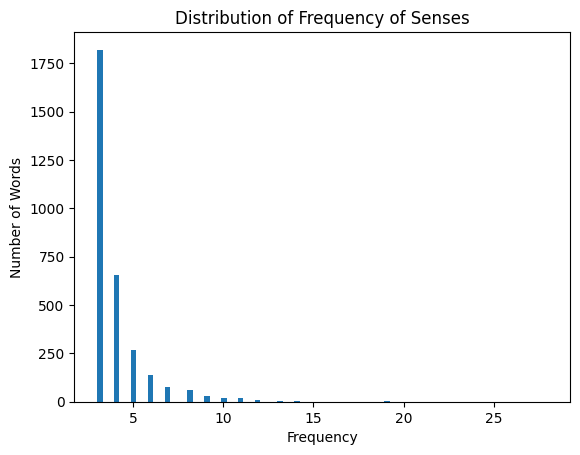

In [53]:
# I want to plot the distribution of the frequency of senses
import matplotlib.pyplot as plt

plt.hist(all_senses['frequency'], bins=80)
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.title('Distribution of Frequency of Senses')
plt.show()


In [43]:
# show me the statics of the frequency
all_senses['frequency'].describe()

count    3112.000000
mean        3.970758
std         1.888259
min         3.000000
25%         3.000000
50%         3.000000
75%         4.000000
max        28.000000
Name: frequency, dtype: float64

In [44]:
# search_value

new_word_senses = all_senses[['search_value', 'defaultValue', 'frequency']]
new_word_senses = new_word_senses.rename(columns={'search_value': 'word', 'defaultValue': 'farsnet_word', 'frequency': 'sense_frequency'})
new_word_senses.sort_values('sense_frequency', ascending=False)
# new_word_senses = new_word_senses.drop_duplicates('word')
new_word_senses = new_word_senses.reset_index(drop=True)
new_word_senses

,word,farsnet_word,sense_frequency
0,خط,خط,28
1,برداشتن,برداشتن,25
2,سر,سر,24
3,گرفتن,گرفتن,23
4,جا,جا,20
...,...,...,...
3107,25 اسفند,25 اسفند,3
3108,عصاره,عصاره,3
3109,10 اردیبهشت,10 اردیبهشت,3
3110,کاربردی,کاربردی,3


In [54]:
# deep copy
new_word_senses_copy = all_senses.copy(deep=True)

In [57]:
# show me rows where words is not equal to farsnet_word
new_word_senses[new_word_senses['word'] != new_word_senses['farsnet_word']]

,word,farsnet_word,sense_frequency
20,ارام,آرام,12
21,اب,آب,12
31,جز,جزئ,11
42,نگهداشتن,نگه‌داشتن,11
51,ردکردن,رد کردن,10
...,...,...,...
3087,انی,آنی,3
3090,13 ابان,13 آبان,3
3092,گیرکردن,گیر کردن,3
3099,10 ابان,10 آبان,3


In [56]:
# apply normalize to the word and farsnet_word
new_word_senses['word'] = optimize_normalize_text(new_word_senses['word'])
new_word_senses['farsnet_word'] = optimize_normalize_text(new_word_senses['farsnet_word'])
new_word_senses

,word,farsnet_word,sense_frequency
0,خط,خط,28
1,برداشتن,برداشتن,25
2,سر,سر,24
3,گرفتن,گرفتن,23
4,جا,جا,20
...,...,...,...
3107,25 اسفند,25 اسفند,3
3108,عصاره,عصاره,3
3109,10 اردیبهشت,10 اردیبهشت,3
3110,کاربردی,کاربردی,3


In [59]:
# save the new_word_senses to csv
new_word_senses.to_csv('./Jun-11-2024/farsnet-words-sense_freq-more-than-3.csv', index=False, encoding='utf-8-sig')

In [45]:
# show me the duplicates
duplicates = new_word_senses[new_word_senses.duplicated('word')]
display(duplicates)
# show me the rows
display(new_word_senses[new_word_senses['word'] == 'جز' ])
display(new_word_senses[new_word_senses['word'] == 'اصلاحکردن' ])

# show me values where word is == to farsnet_word
new_word_senses[new_word_senses['word'] == new_word_senses['farsnet_word']]
display(new_word_senses)


,word,farsnet_word,sense_frequency


,word,farsnet_word,sense_frequency
31,جز,جزئ,11


,word,farsnet_word,sense_frequency
184,اصلاحکردن,اصلاح کردن,7


,word,farsnet_word,sense_frequency
0,خط,خط,28
1,برداشتن,برداشتن,25
2,سر,سر,24
3,گرفتن,گرفتن,23
4,جا,جا,20
...,...,...,...
3107,25 اسفند,25 اسفند,3
3108,عصاره,عصاره,3
3109,10 اردیبهشت,10 اردیبهشت,3
3110,کاربردی,کاربردی,3


In [29]:
new_all_senses = all_senses[['defaultValue', 'frequency']]

# rename frequency to sense_frequency and default value to farsnet_word
new_all_senses = new_all_senses.rename(columns={'defaultValue': 'farsnet_word', 'frequency': 'sense_frequency'})

# sort by it
new_all_senses = new_all_senses.sort_values('sense_frequency', ascending=False)
# reset index
new_all_senses = new_all_senses.reset_index(drop=True)

new_all_senses

,farsnet_word,sense_frequency
0,خط,28
1,برداشتن,25
2,سر,24
3,گرفتن,23
4,جا,20
...,...,...
2907,برهمن,3
2908,سه‌پايه,3
2909,بروبيا,3
2910,پسته‌اي,3


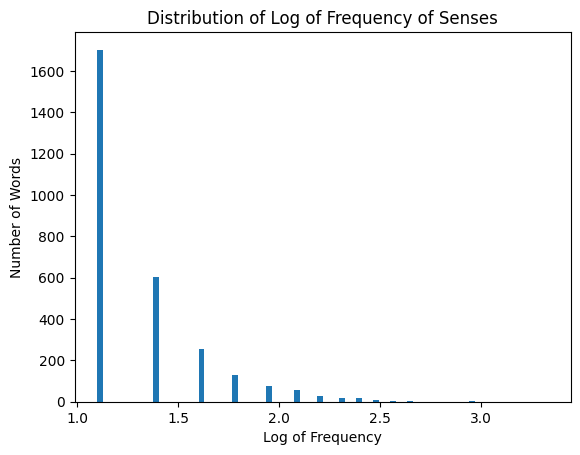

In [30]:
# show me the sense_frequency using log on a plot
import numpy as np
import matplotlib.pyplot as plt

plt.hist(np.log(new_all_senses['sense_frequency']), bins=80)
plt.xlabel('Log of Frequency')
plt.ylabel('Number of Words')
plt.title('Distribution of Log of Frequency of Senses')
plt.show()


In [31]:
# and show me the statistics of the log of frequency
np.log(new_all_senses['sense_frequency']).describe()

count    2912.000000
mean        1.315089
std         0.327541
min         1.098612
25%         1.098612
50%         1.098612
75%         1.386294
max         3.332205
Name: sense_frequency, dtype: float64

In [28]:
import os
if not os.path.exists('Jun-11-2024'):
    os.makedirs('Jun-11-2024')

In [32]:
# ذخیره تمام این کلمات و تعداد معنا‌های متناظر در یک فایل csv
timestamp = datetime.datetime.now().strftime("%d-%m-%Y")
new_all_senses.to_csv(f'./Jun-11-2024/Farsnet-wrods-with-more-than-3-senses-{timestamp}.csv', index=False, encoding='utf-8-sig')

In [28]:
# capture first 500 rows
all_senses = all_senses.head(500)
display(all_senses)

import datetime
# save to csv as word,frequency only two columns
timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
all_senses[['search_value', 'frequency']].to_csv(f'words_500-top-sense-freq-Farsnet-{timestamp}.csv', index=False)



,id,search_value,synset,pos,semanticCategory,example,gloss,frequency
0,30203,خط,12337,Noun,SHAPE,--نامعلوم--:خط راست. خط منحني *,--نامعلوم--:شکلي که از به دنبال هم قرار گرفتن ...,28
1,49975,برداشتن,18239,Verb,change,سنگيني وزنه ها را از من برداشتند.,جدا کردن و دور کردن چيزي از کسي,25
2,25615,سر,11887,Noun,LOCATION,--نامعلوم--:کمباين فقط سر گندمها را مي چيد. عن...,--نامعلوم--:بخش بالايي هر چيزي *,24
3,143691,گرفتن,45211,Noun,ACT,--ازخودم--:سلب‌کردن وي از مقامش بايد توسط مدير...,--ساير--:کسي را از چيزي يا انجام کاري محروم يا...,23
4,29292,جا,11879,Noun,LOCATION,او اشتباهاً جاي کس ديگري نشسته بود. ما جاههايم...,"فضايي که براي نشستن( در تئاتر, قطار, هواپيماو ...",20
...,...,...,...,...,...,...,...,...
495,27029,اضافه,13812,Noun,COMMUNICATION,--نامعلوم--:اضافه را در جمله زير مشخص کنيد *,--نامعلوم--:حالت دستوي که ارتباط يک اسم يا گرو...,5
496,141300,دريده,15361,Adverb,حالت,--نامعلوم--:گستاخانه با والدين خود صحبت نکنيد ...,--نامعلوم--:با بي ادبي و گستاخي *,5
497,145343,شکارچي,17196,Adjective,behavior,--نامعلوم--:ببر از حيوانات شکارچي است *,--نامعلوم--:ويژگي حيواني که شکار مي‌کند *,5
498,21523,شنيدن,7809,Verb,social,--نامعلوم--:به حرف شما که نجات دنيا و آخرت بود...,--نامعلوم--:حرفي را پذيرفتن و به آن عمل کردن *,5


In [8]:
display(all_senses)

,id,search_value,synset,pos,semanticCategory,example,gloss,frequency
35811,30203,خط,12337,Noun,SHAPE,--نامعلوم--:خط راست. خط منحني *,--نامعلوم--:شکلي که از به دنبال هم قرار گرفتن ...,28
16144,49975,برداشتن,18239,Verb,change,سنگيني وزنه ها را از من برداشتند.,جدا کردن و دور کردن چيزي از کسي,25
52017,25615,سر,11887,Noun,LOCATION,--نامعلوم--:کمباين فقط سر گندمها را مي چيد. عن...,--نامعلوم--:بخش بالايي هر چيزي *,24
108094,143691,گرفتن,45211,Noun,ACT,--ازخودم--:سلب‌کردن وي از مقامش بايد توسط مدير...,--ساير--:کسي را از چيزي يا انجام کاري محروم يا...,23
29219,29292,جا,11879,Noun,LOCATION,او اشتباهاً جاي کس ديگري نشسته بود. ما جاههايم...,"فضايي که براي نشستن( در تئاتر, قطار, هواپيماو ...",20
...,...,...,...,...,...,...,...,...
4021,104892,ارش,33476,Noun,QUANTITY,ذرع مقداري باشد معين از سر انگشتِ ميانينِ يک د...,واحد طول معادل 104 سانتي‌متر,3
103586,162026,کتوکلفت,46,Adjective,relation,--نامعلوم--:پدرش پولدار است * سخن:آدم کت‌وکلفت...,--نامعلوم--:داراي ثروت و امکانات مناسب براي گذ...,3
75526,49309,متقلب,17750,Adjective,behavior,فروشنده متقلب، جنس را دو برابر قيمت فروخت,ويژگي آن که تقلب مي کند,3
8935,14088,الکترونيکي,1194,Adjective,material,فروشگاه کالاهاي الکترونيکي,مربوط به دستگاه هاي الکتروني مانند ترانزيستور،...,3


In [27]:
sample = all_senses.sample(n=500)
display(sample)

,id,search_value,synset,pos,semanticCategory,example,gloss,frequency
51969,31931,سد,12754,Noun,ARTIFACT,--نامعلوم--:فنس‌هاي اطراف مزرعه مانع حرکت و ب...,--نامعلوم--:هر ساختار يا شيء که جلوي حرکت را م...,3
23397,28432,تجاوز,10604,Noun,ACT,--نامعلوم--:تجاوز به حقوق شخصي ديگران جرم است *,--نامعلوم--:دست درازي کردن به حق کسي *,3
49141,48819,زعفراني,17419,Adjective,material,بستني زعفراني خوشمزه بود چون از مزه زعفران خوش...,آميخته با زعفران يا عطرمايه آن,3
84352,64529,نااگاه,19087,Adjective,social,صاحب خانه بي خبر از دزدي در محله، در خانه اش ر...,ويژگي آن که از چيزي اطلاع ندارد,3
54036,65255,سنبله,27435,Noun,OBJECT,--نامعلوم--:صورت فلکي سنبله يکي از قديمي‌ترين ...,--نامعلوم--:از صورت‌هاي فلکي منطقةالبروجي است....,3
...,...,...,...,...,...,...,...,...
52688,31983,سرعت,11230,Noun,ATTRIBUTE,سرعت بچه ها خوب بود,تندي حرکت يا کار,3
43167,134691,دوچرخهسوار,42537,Adjective,social,وب:دبيرکل ستاد ملي مبارزه با دوپينگ از مثبت اع...,سخن:ويژگي ورزشکاري که به ورزش دوچرخه‌سواري مي‌...,4
25710,28801,تعريف,10749,Noun,ACT,--نامعلوم--:يک ستاره ورزشي مي تواند پول زيادي ...,--نامعلوم--:بيان محاسن و مزايا و ويژگي‌هاي مثب...,5
86195,17057,نرم,80,Adjective,conceptual,--نامعلوم--:پارچه نرم * --نامعلوم--:پوست لطيف *,--نامعلوم--:ويژگي جسمي که هنگام لمس آن احساس ل...,6


In [28]:
max_freq = sample['frequency'].max()
print(max_freq)

28


In [33]:
# sort sample by frequency
display(sample.sort_values('frequency', ascending=False))

,id,search_value,synset,pos,semanticCategory,example,gloss,frequency
35811,30203,خط,12337,Noun,SHAPE,--نامعلوم--:خط راست. خط منحني *,--نامعلوم--:شکلي که از به دنبال هم قرار گرفتن ...,28
62531,32974,طرح,11500,Noun,COMMUNICATION,پيشنهاد اين موضوع بايد به بعد موکول مي شد,عمل مطرح نمودن موضوعي براي آن که بررسي و پذيرف...,15
45158,20906,رسيدن,7551,Verb,motion,--نامعلوم--:براي اينکه دستم به سقف برسد چهارپا...,--نامعلوم--:امکان دستيابي و لمس چيزي را داشتن *,12
670,24756,اب,14737,Noun,PERSON,پدر، پسر و روح القدس,يکي از اقنوم هاي سه گانه در مسيحيت,12
56649,32356,شانه,11291,Noun,BODY,شانه اش درد مي کند,هر يک از دو بخش بالايي تنه که بين گردن و قسمت...,10
...,...,...,...,...,...,...,...,...
84441,35745,نابودي,11575,Noun,EVENT,انهدام و ويراني خانه پس از زلزله باعث رفتن آنه...,رخداد يا نتيجه‌ي رخداد که به از بين رفتن کامل ...,5
29985,48086,جداساختن,16912,Verb,motion,--نامعلوم--:چون يقيني که همه از تو جدا خواهند ...,--نامعلوم--:از کسي يا چيزي دور کردن *,5
32982,153320,حسابي,47555,Adjective,material,--ازخودم--:کارش يک است * سخن:سور نصرت‌الملک خي...,--ازخودم--:بسيار خوب *,5
44025,31025,ذکر,14656,Noun,COMMUNICATION,او ذکر را در هيچ حالتي فراموش نمي کند,ياد کردن از خداوند,5


In [31]:
sample = sample[sample['frequency'] >= 5]

In [32]:
display(sample)

,id,search_value,synset,pos,semanticCategory,example,gloss,frequency
81459,35345,منبع,10099,Noun,PROCESS,خورشيد منبع اصلي نور و گرما براي زمين است.,فيزيک: نقطه يا بخشي از سيستم که از آن جا انرژي...,7
54667,21368,سوختن,16931,Verb,weather,شمع ها مي سوختند.,به شدت درخشيدن همراه با گرما,8
44358,20834,راندن,8571,Verb,emotion,--نامعلوم--:هر چه سعي مي کنم نمي توانم فکرش را...,--نامعلوم--:چيزي را از خود جدا کردن و راندن *,5
96224,23234,پخشکردن,7949,Verb,communication,--نامعلوم--:آيين محمد را در سرتاسر جهان آن روز...,--نامعلوم--:چيزي را گسترش دادن و عموم مردم را ...,6
53277,15519,سست,1228,Adjective,material,--نامعلوم--:گره طناب سست بود و سطل آويخته به آ...,--نامعلوم--:بدون استحکام، پايداري و استواري لا...,5
...,...,...,...,...,...,...,...,...
25470,28751,تصوير,12378,Noun,STATE,--نامعلوم--:تصوير انتخابات مخدوش گرديد *,--نامعلوم--:اوضاع را به شکل شيئي قابل مشاهده ف...,6
11407,64012,اول,26857,Adverb,ترتيب,در آغاز از حضور همه عزيزان سپاسگزاري مي‌کنم.,در ابتداي امر، به عنوان مقدمه,7
87669,36117,نماينده,13652,Noun,PERSON,نماينده ي دائم ايران در سازمان ملل,کسي که از سوي نهاد يا دولتي براي انجام کاري يا...,7
25710,28801,تعريف,10749,Noun,ACT,--نامعلوم--:يک ستاره ورزشي مي تواند پول زيادي ...,--نامعلوم--:بيان محاسن و مزايا و ويژگي‌هاي مثب...,5


In [ ]:
words = all_senses['search_value'].tolist()
print(words)

In [ ]:
# all_senses = all_senses[(all_senses['frequency'] >= 7) & (all_senses['frequency'] <= 15)]
# display(all_senses)
print(len(all_senses))
words = all_senses['search_value'].tolist()
print(words)

In [ ]:
# normalize function - revers of denormalize
def normalize(token):
    return token.replace("ي", "ی")

# apply normalize function to all words
all_senses['search_value'] = all_senses['search_value'].apply(normalize)

In [ ]:
# import pandas as pd

timestamp = pd.to_datetime('now').strftime('%m-%d-%Y_%H-%M-%S')
words = all_senses['search_value'].rename('word')
words.to_csv(f'words_{timestamp}.csv', index=False, header=True, encoding='utf-8-sig')

In [ ]:
words = all_senses['search_value']
words = words.rename('word')
words.to_csv('words.csv', index=False, header='word')

In [ ]:
multiple_senses = fars_graph.synsets_with_multiple_senses()
display(multiple_senses)

In [ ]:
all_synsets_for_all_words = fars_graph.get_all_synsets_for_all_words()
display(all_synsets_for_all_words)

In [ ]:
# Retrieve words with their most common sense
common_sense_words = fars_graph.words_with_most_common_sense()
display(common_sense_words)

# Sort by frequency in descending order
sorted_common_sense_words = common_sense_words.sort_values(by='frequency', ascending=False)
display(sorted_common_sense_words)

In [ ]:
synsets_lexicon = fars_graph.synsets_with_lexicon_info()
display(synsets_lexicon)

In [ ]:
senses_pos = fars_graph.senses_by_pos('Noun')
display(senses_pos)

In [ ]:
senses_distribution = fars_graph.senses_distribution()
display(senses_distribution)

In [ ]:
unique_senses_category = fars_graph.unique_senses_by_semantic_category('material')
display(unique_senses_category)

In [ ]:
gloss_pattern = fars_graph.synsets_with_gloss_pattern('نامعلوم')
display(gloss_pattern)

In [ ]:
no_mapping_synsets = fars_graph.synsets_with_no_mapping()
display(no_mapping_synsets)

In [ ]:
unique_senses_category = fars_graph.unique_senses_by_semantic_category('body')
display(unique_senses_category)

In [ ]:
# Retrieve examples for synsets with a specific gloss pattern
gloss_pattern = fars_graph.synsets_with_gloss_pattern('ازخودم')
display(gloss_pattern)

In [ ]:
# Find synsets with no direct mapping and their glosses
no_mapping_synsets = fars_graph.synsets_with_no_mapping()
display(no_mapping_synsets)

In [ ]:
import json
# list items in merged_senses_for_words.json that in descending order based on value
with open('merged_senses_for_words.json', encoding='utf8') as JSONFile:
    data = json.load(JSONFile)
    
    # Sort the dictionary by value in descending order 
    sorted_data = {k: v for k, v in sorted(data.items(), key=lambda item: len(item[1]), reverse=True)}
    print(sorted_data)


# show words to me as a dataframe with their len(value)
import pandas as pd
words = pd.DataFrame(sorted_data.items(), columns=['word', 'senses'])
words['len'] = words['senses'].apply(len)

# save as csv
words.to_csv('words.csv', index=False)


In [ ]:
# show words with less than <= 6 senses as a list
words = words[words['len'] <= 6]
print(words['word'].tolist())

In [ ]:
# save to csv 
# only save words and len  to csv from words dataframe
words = words[['word', 'len']]
words.to_csv('armin_words_to_label.csv', index=False)

In [ ]:
import json
# read merged_senses_for_words.json
with open('merged_senses_for_words.json', encoding='utf8') as JSONFile:
    data = json.load(JSONFile)
    
    # Sort the dictionary by value in descending order 
    sorted_data = {k: v for k, v in sorted(data.items(), key=lambda item: len(item[1]), reverse=True)}
    print(sorted_data)


In [ ]:
# save first 100 items in sorted_data to a new json file 
import json
# save the first 100 items in sorted_data to a new JSON file
with open('top_100_words.json', 'w', encoding='utf8') as JSONFile:
    json.dump({k: sorted_data[k] for k in list(sorted_data)[:100]}, JSONFile, ensure_ascii=False, indent=4)



In [ ]:
# provide top 100 words as a list
# one_hundred = list(sorted_data.keys())[:100]
# print(one_hundred)



In [ ]:
# remove "semantic_category", "sense_id" and "synset_id" from 100 words in top_100_words.json
import json
# Load the JSON file
with open('top_100_words.json', encoding='utf8') as JSONFile:
    data = json.load(JSONFile)
    
# Remove the specified keys from each word
for word, senses in data.items():
    for sense in senses:
        sense.pop('semantic_category', None)
        sense.pop('sense_id', None)
        sense.pop('synset_id', None)

In [ ]:
# save the modified data to a new JSON file
with open('dorsa_words.json', 'w', encoding='utf8') as JSONFile:
    json.dump(data, JSONFile, ensure_ascii=False, indent=4)